In [125]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np

from itertools import compress #filter list with bolean mask

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.feature_selection import RFE #recursive feature elimination
import sklearn.metrics as metr

from imblearn.over_sampling import SMOTE

import statsmodels.api as sm

import matplotlib.pyplot as plt
plt.rc("font", size=14)

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [126]:
#%% IMPORT DATASET

filename = "WA_Fn-UseC_-Telco-Customer-Churn.csv"
data_init = pd.read_csv(filename, header=0)

# print dimensions
print("Dimensions: ", data_init.shape)

# print columns
print("Fields: \n", list(data_init.columns))

# print nulls
print("Nulls: ", data_init.isnull().sum().values.sum())

# first rows
data_init.head()

Dimensions:  (7043, 21)
Fields: 
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']
Nulls:  0


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [127]:
#%% DATA PREPARATION

# convert variables
data_init["TotalCharges"] = data_init["TotalCharges"].replace({' ': 0})
data_init["TotalCharges"] = data_init["TotalCharges"].astype(float)  

data_init = data_init.replace({'No phone service': 'No'})
data_init = data_init.replace({'No internet service': 'No'})

data_init["SeniorCitizen"] = data_init["SeniorCitizen"].replace({1:"Yes",0:"No"})
data_init["gender"] = data_init["gender"].replace({"Female": "Yes","Male": "No"})
data_init = data_init.rename(columns={"gender":"Female"})


# table of infos for each variable
data_info = pd.DataFrame(data_init.dtypes).rename(columns={0:"dtypes"})
data_info = pd.concat([data_info, data_init.nunique()], 
                       axis=1).rename(columns={0:"unique"})
data_info

,dtypes,unique
customerID,object,7043
Female,object,2
SeniorCitizen,object,2
Partner,object,2
Dependents,object,2
tenure,int64,73
PhoneService,object,2
MultipleLines,object,2
InternetService,object,3
OnlineSecurity,object,2


In [128]:
# encoding binary variables
binar_ind = [i for i, val in enumerate(data_info["unique"]) if val==2]
binar_cols = list(data_info.index[binar_ind])

le = preprocessing.LabelEncoder()
le.fit(data_init["Partner"]) # Yes=1
data_bin = data_init[binar_cols].astype(str).apply(le.transform)

# encoding non binary variables
to_hot_enc = [i for i, val in enumerate(data_info["unique"]) if 2<val<=4]
to_hot_enc_cols = list(data_info.index[to_hot_enc])

ohe = preprocessing.OneHotEncoder()
feature_arr = ohe.fit_transform(data_init[to_hot_enc_cols]).toarray()
feature_names = ohe.get_feature_names(data_init[to_hot_enc_cols].columns)
data_no_bin = pd.DataFrame(feature_arr, columns=feature_names)

# removing multicollinearity
cols_to_del = data_info["unique"][to_hot_enc]
cols_to_del = np.array(np.cumsum(cols_to_del)) -1
print("I removed:" + str(list(data_no_bin.columns[cols_to_del])))
data_no_bin.drop(data_no_bin.columns[cols_to_del], axis=1, inplace=True)

# merging the encoded variables + not encoded
numer_cols = [col for col in data_init.columns if col not in binar_cols + to_hot_enc_cols]
data = pd.concat([data_init[numer_cols], data_no_bin, data_bin], axis=1)

data.head()

I removed:['InternetService_No', 'Contract_Two year', 'PaymentMethod_Mailed check']


,customerID,tenure,MonthlyCharges,TotalCharges,InternetService_DSL,InternetService_Fiber optic,Contract_Month-to-month,Contract_One year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),...,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,Churn
0,7590-VHVEG,1,29.85,29.85,1.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1,5575-GNVDE,34,56.95,1889.50,1.0,0.0,0.0,1.0,0.0,0.0,...,1,0,1,0,1,0,0,0,0,0
2,3668-QPYBK,2,53.85,108.15,1.0,0.0,1.0,0.0,0.0,0.0,...,1,0,1,1,0,0,0,0,1,1
3,7795-CFOCW,45,42.30,1840.75,1.0,0.0,0.0,1.0,1.0,0.0,...,0,0,1,0,1,1,0,0,0,0
4,9237-HQITU,2,70.70,151.65,0.0,1.0,1.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,1,1


In [129]:
# removing observation with tenure=0 (no info on churn)
data = data[data.tenure!=0]

summary = np.around(data.describe().transpose(), 2)
summary

# as we can see, the churn concerns around 27% of the clients of the dataset

,count,mean,std,min,25%,50%,75%,max
tenure,7032.0,32.42,24.55,1.00,9.00,29.00,55.00,72.00
MonthlyCharges,7032.0,64.80,30.09,18.25,35.59,70.35,89.86,118.75
TotalCharges,7032.0,2283.30,2266.77,18.80,401.45,1397.48,3794.74,8684.80
InternetService_DSL,7032.0,0.34,0.47,0.00,0.00,0.00,1.00,1.00
InternetService_Fiber optic,7032.0,0.44,0.50,0.00,0.00,0.00,1.00,1.00
Contract_Month-to-month,7032.0,0.55,0.50,0.00,0.00,1.00,1.00,1.00
Contract_One year,7032.0,0.21,0.41,0.00,0.00,0.00,0.00,1.00
PaymentMethod_Bank transfer (automatic),7032.0,0.22,0.41,0.00,0.00,0.00,0.00,1.00
PaymentMethod_Credit card (automatic),7032.0,0.22,0.41,0.00,0.00,0.00,0.00,1.00
PaymentMethod_Electronic check,7032.0,0.34,0.47,0.00,0.00,0.00,1.00,1.00


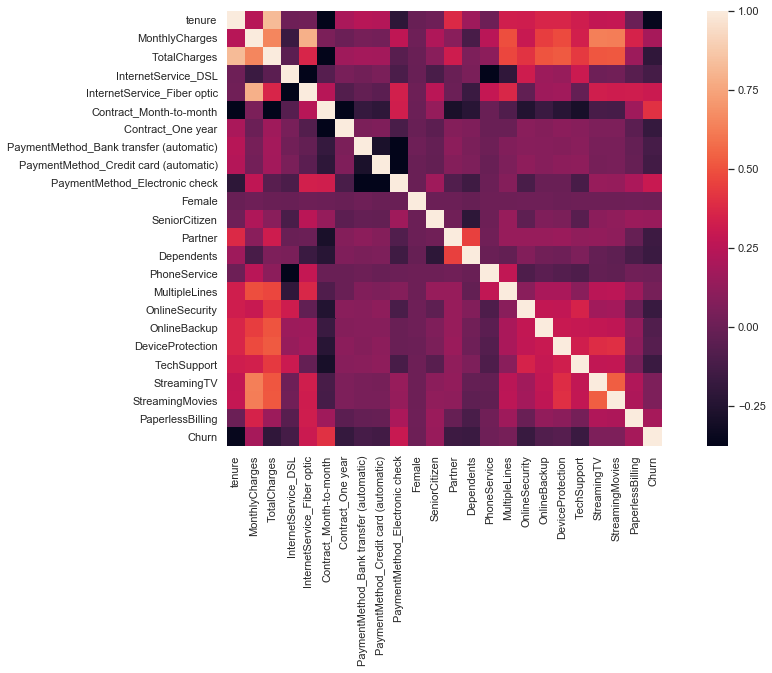

In [130]:
#%% EXPLORATORY ANALYSIS

#correlation
correl = data.corr()
plt.figure(figsize=(16, 8))
sns.heatmap(correl, robust=True, square=True, xticklabels=True, yticklabels=True)
plt.show()

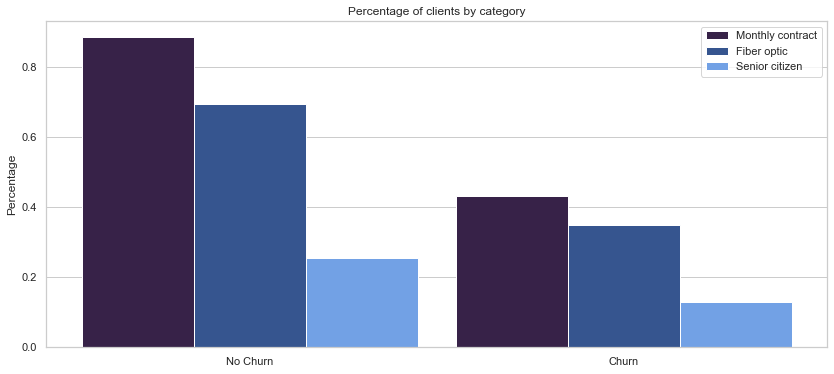

In [131]:
# as we can see, there are hints of a relationship betwen churn and other variables, for example:
# - tenure: inverse relationship, the longer the tenure the less likely is the churn
# - month-to-month contract: it's easier for the client to abandon
# - optic.fiber, electronic check, paperless billing: clients at ease with technology change more often
# - senior citizens: change often (would be nice to have clients'age)
# let's have a look to these variables.

churn = data[data.Churn == 1]
no_churn = data[data.Churn == 0]

#bar plot
divisions = ["No Churn", "Churn"]
plt_index = np.arange(2) #[0,1]
width = 0.3
contract_bars = np.divide([churn["Contract_Month-to-month"].sum(), 
                           no_churn["Contract_Month-to-month"].sum()],
                            [churn.shape[0],no_churn.shape[0]])
fiber_bars = np.divide([churn["InternetService_Fiber optic"].sum(), 
                           no_churn["InternetService_Fiber optic"].sum()],
                            [churn.shape[0],no_churn.shape[0]])
senior_bars = np.divide([churn["SeniorCitizen"].sum(), 
                           no_churn["SeniorCitizen"].sum()],
                            [churn.shape[0],no_churn.shape[0]])

plt.figure(figsize=(14, 6))
plt.bar(plt_index, contract_bars, width, color="#372248", label="Monthly contract")
plt.bar(plt_index+width, fiber_bars, width, color="#36558F", label="Fiber optic")
plt.bar(plt_index+width+width, senior_bars, width, color="#72A1E5", label="Senior citizen")

plt.title("Percentage of clients by category")
plt.ylabel("Percentage")
plt.xticks(plt_index + width, divisions)

plt.legend(loc="best")
plt.gca().xaxis.grid(False)
plt.show()

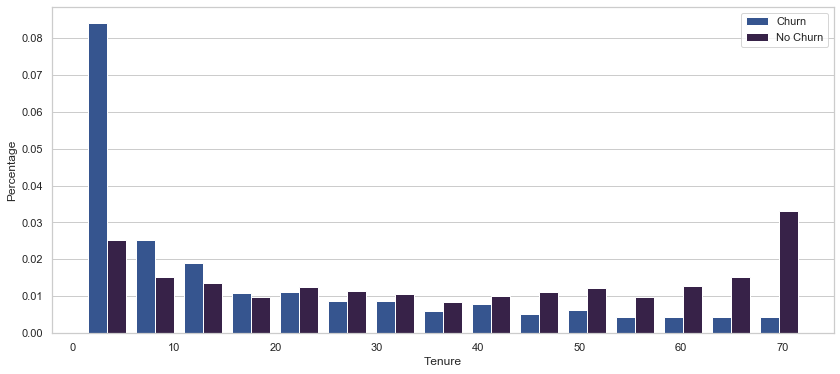

In [132]:
# histogram

plt.figure(figsize=(14, 6))
plt.hist([churn.tenure, no_churn.tenure], 
         bins= "auto", color=["#36558F", "#372248"], 
         label=["Churn", "No Churn"], density=True)
plt.legend(loc='best')
plt.ylabel("Percentage")
plt.xlabel("Tenure")
plt.gca().xaxis.grid(False)
plt.show()

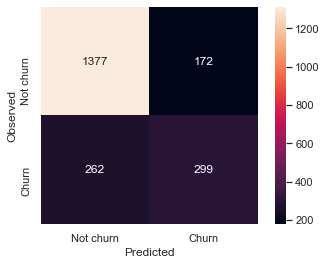

Accuracy score: 0.7943127962085308
Recall score: 0.5329768270944741
Precision score: 0.6348195329087049
F1 score: 0.5794573643410853


In [133]:
#%% LOGISTIC REGRESSION

# setting up testing and training sets
X = data.drop(["customerID", "Churn"], axis=1, inplace=False)
y = data.Churn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# logistic regression
logistic = LogisticRegression(solver='liblinear').fit(X_train, y_train)
pred = logistic.predict(X_test)

# confusion matrix
def conf_matrix(y_test, pred):
    conf_matrix = metr.confusion_matrix(y_test, pred)
    confusion = sns.heatmap(conf_matrix, square=True, robust=True, 
                xticklabels=["Not churn","Churn"], 
                yticklabels=["Not churn","Churn"],
                annot=True, fmt='.0f')
    plt.xlabel("Predicted")
    plt.ylabel("Observed")
    plt.show()

# metrics
conf_matrix(y_test, pred)
print("Accuracy score:", metr.accuracy_score(y_test, pred)) #correct predictions/total predictions
print("Recall score:", metr.recall_score(y_test, pred)) # TP/(TP+FN): indicates a small number of False Negatives
print("Precision score:", metr.precision_score(y_test, pred)) # TP/(TP+FP): indicates a small number of False Positives
print("F1 score:", metr.f1_score(y_test, pred)) #harmonic mean of precision and recall (punishes extreme values more)
# In "F1" the number 1 means same importance to preision and recall, more generally: F-beta

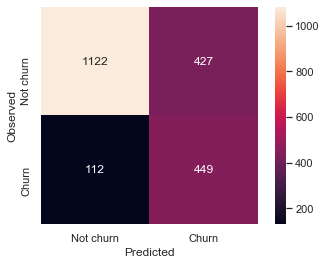

Accuracy score: 0.7445497630331753
Recall score: 0.8003565062388592
Precision score: 0.5125570776255708
F1 score: 0.6249130132219902


In [134]:
#%% LOGISTIC REGRESSION WITH OVERSAMPLING

# preparing oversampling
train_data = pd.concat([X_train, y_train], axis=1)
churn = train_data[train_data.Churn == 1]
no_churn = train_data[train_data.Churn == 0]

churn_upsampled = resample(churn, 
                           replace=True, #sample with replacement
                           n_samples=len(no_churn), #match number of no_churn
                           random_state=42)

# combine majority and upsampled minority
upsampled = pd.concat([no_churn, churn_upsampled])

y_train_upsampled = upsampled.Churn
X_train_upsampled = upsampled.drop('Churn', axis=1)

# logistic regression
logistic_upsampled = LogisticRegression(solver='liblinear').fit(X_train_upsampled, y_train_upsampled)
upsampled_pred = logistic_upsampled.predict(X_test)

# metrics
conf_matrix(y_test, upsampled_pred)
print("Accuracy score:", metr.accuracy_score(y_test, upsampled_pred)) 
print("Recall score:", metr.recall_score(y_test, upsampled_pred))
print("Precision score:", metr.precision_score(y_test, upsampled_pred)) 
print("F1 score:", metr.f1_score(y_test, upsampled_pred)) 

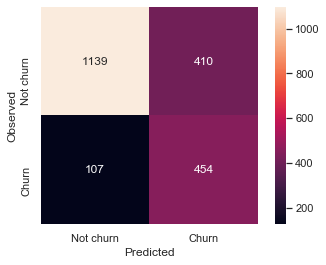

Accuracy score: 0.7549763033175355
Recall score: 0.8092691622103387
Precision score: 0.5254629629629629
F1 score: 0.6371929824561403


In [135]:
#%% LOGISTIC REGRESSION WITH SMOTE (Sintetic Minority Oversampling Technique)

# creating sintetic observations
smote = SMOTE(random_state=42, ratio=1.0)
X_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)
X_train_sm = pd.DataFrame(X_train_sm, columns=X_train.columns.tolist())
y_train_sm = pd.DataFrame(y_train_sm, 
                          columns=pd.DataFrame(y_train).columns.tolist()).values.ravel()

# logistic regression
logist_smote = LogisticRegression(solver='liblinear').fit(X_train_sm, y_train_sm)
smote_pred = logist_smote.predict(X_test)

# metrics
conf_matrix(y_test, smote_pred)
print("Accuracy score:", metr.accuracy_score(y_test, smote_pred)) 
print("Recall score:", metr.recall_score(y_test, smote_pred)) 
print("Precision score:", metr.precision_score(y_test, smote_pred)) 
print("F1 score:", metr.f1_score(y_test, smote_pred)) 

In [136]:
#%% SELECTING SIGNIFICANT VARIABLES

#we will use the smote training set (higher AIC and BIC)
logit_model=sm.Logit(y_train_sm,X_train_sm)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.461778
         Iterations 7
                                     Results: Logit
Model:                      Logit                    Pseudo R-squared:         0.334    
Dependent Variable:         y                        AIC:                      6721.4584
Date:                       2019-09-23 14:45         BIC:                      6879.8299
No. Observations:           7228                     Log-Likelihood:           -3337.7  
Df Model:                   22                       LL-Null:                  -5010.1  
Df Residuals:               7205                     LLR p-value:              0.0000   
Converged:                  1.0000                   Scale:                    1.0000   
No. Iterations:             7.0000                                                      
----------------------------------------------------------------------------------------
                                         Coef

In [137]:
to_drop = ["PhoneService", "Partner"]
X_train_reduced = X_train_sm.drop(to_drop, axis=1, inplace=False)

#we fit the model with reduced number of variables
logit_model=sm.Logit(y_train_sm,X_train_reduced)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.462042
         Iterations 7
                                     Results: Logit
Model:                      Logit                    Pseudo R-squared:         0.333    
Dependent Variable:         y                        AIC:                      6721.2767
Date:                       2019-09-23 14:45         BIC:                      6865.8768
No. Observations:           7228                     Log-Likelihood:           -3339.6  
Df Model:                   20                       LL-Null:                  -5010.1  
Df Residuals:               7207                     LLR p-value:              0.0000   
Converged:                  1.0000                   Scale:                    1.0000   
No. Iterations:             7.0000                                                      
----------------------------------------------------------------------------------------
                                         Coef

In [138]:
to_drop = ["PhoneService",
           "Partner",
           "Female", 
           "PaymentMethod_Bank transfer (automatic)", 
           "OnlineBackup", 
           "PaymentMethod_Credit card (automatic)", 
           "DeviceProtection"]
X_train_reduced = X_train_sm.drop(to_drop, axis=1, inplace=False)

#we fit the model with reduced number of variables
logit_model=sm.Logit(y_train_sm,X_train_reduced)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.462758
         Iterations 7
                                Results: Logit
Model:                   Logit                 Pseudo R-squared:      0.332    
Dependent Variable:      y                     AIC:                   6721.6305
Date:                    2019-09-23 14:45      BIC:                   6831.8020
No. Observations:        7228                  Log-Likelihood:        -3344.8  
Df Model:                15                    LL-Null:               -5010.1  
Df Residuals:            7212                  LLR p-value:           0.0000   
Converged:               1.0000                Scale:                 1.0000   
No. Iterations:          7.0000                                                
-------------------------------------------------------------------------------
                                Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------

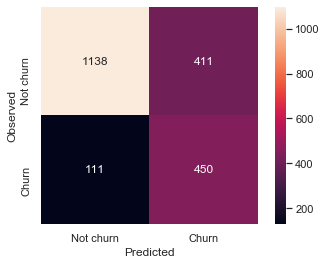

Accuracy score: 0.75260663507109
Recall score: 0.8021390374331551
Precision score: 0.5226480836236934
F1 score: 0.6329113924050633


In [153]:
# prediction
X_test_reduced = X_test.drop(to_drop, axis=1, inplace=False)
threshold = 0.5 #symmetric loss function
reduced_pred_prob = result.predict(X_test_reduced)
reduced_pred = (reduced_pred_prob > threshold).astype(int)

# metrics
conf_matrix(y_test, reduced_pred)
print("Accuracy score:", metr.accuracy_score(y_test, reduced_pred)) 
print("Recall score:", metr.recall_score(y_test, reduced_pred)) 
print("Precision score:", metr.precision_score(y_test, reduced_pred)) 
print("F1 score:", metr.f1_score(y_test, reduced_pred)) 

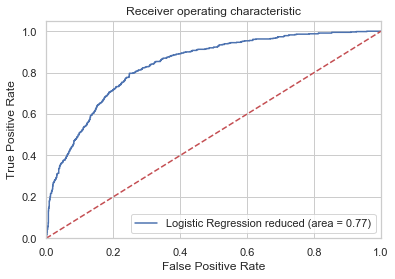

In [155]:
logit_roc_auc = metr.roc_auc_score(y_test, reduced_pred)
fpr, tpr, thresholds = metr.roc_curve(y_test, reduced_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression reduced (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()